# Backdoor Adjustment Example

## Outline

[Setup](#setup)

[Overview: Systematically adjusting for observed confounding](#overview-systematically-adjusting-for-observed-confounding)
- [Task: Treatment effect estimation with observational data](#task-treatment-effect-estimation-with-observational-data)
- [Challenge: Confounding](#challenge-confounding)
- [Assumptions: All confounders observed](#assumptions-all-confounders-observed)
- [Intuition: Statistically adjusting for confounding](#intuition-statistically-adjusting-for-confounding)

[Example: Evaluating the impact of a job training program](#example-evaluating-the-impact-of-a-job-training-program)
- [Variables](#variables)
- [Motivation](#motivation)
- [Source](#source)

[Causal Probabilistic Program](#causal-probabilistic-program)
- [Model Description](#model-description)
- [Prior Description](#prior-description)
- [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)

[Causal Query: average treatment effect](#causal-query-average-treatment-effect-ate)

[Causal Inference as Probabilistic Inference](#causal-inference-as-probabilistic-inference)
- [Maximum Likelihood Inference](#maximum-likelihood-inference)
- [Maximum a Posteriori Inference](#maximum-a-posteriori-inference)

[Results](#results)


## Setup

Here, we install the necessary Pytorch, Pyro, and Causal Pyro dependencies for this example.

In [2]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyro.nn import PyroModule, PyroSample
from pyro.poutine import replay, trace

from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer.autoguide.structured import AutoStructured
from pyro.infer import SVI, Predictive

from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual

## Overview: Systematically adjusting for observed confounding


### **Task:** Treatment effect estimation with observational data
In this example, we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X = \{X_1, ..., X_d\}$. 

In this example we'll assume that $T$ is a binary random variable, but the concepts carry over exactly when $T$ is continuous or discrete-ordinal.

### **Challenge:** Confounding

Unfortunately, naively estimating the effect of an intervention by simply approximating $P(Y|T)$ alone may produce poor estimates of $T$'s effect on $Y$. In these kinds of *observational* settings, some collection of variables $Z = \{Z_1, ..., Z_{d'}\}$ may influence both $T$ and $Y$, resulting in a statistical dependence that is not reflective of the causal effect we are interested in estimating. These variables are called "confounders", and pose a serious problem for drawing causal conclusions from observational data.

### **Assumptions:** All confounders observed

In this example we assume that all confounders between $T$ and $Y$ are observed. In other words, $Z \subseteq X$.

For technical reasons that are out of scope of this tutorial [@cinelli2020crash], we also assume that no elements of $X$ are common effects of $T$ and $Y$, nor are they influenced by any sets of variables $U_1$, $U_2$ such that $U_1$ influences $T$ and $U_2$ influences $Y$. This somewhat more technical assumption avoids the possibility of "collider bias", also sometimes refered to as "Berkson's paradox". See https://en.wikipedia.org/wiki/Berkson%27s_paradox for more discussion of Berkson's paradox.

### **Intuition:** Statistically adjusting for confounding



If all of the confounders are observed, then we can imagine partitioning our data instances into subsets of instances that have similar values of $X$ and then estimating the statistical dependence between $T$ and $Y$ within each subset of instances. Because we've assumed that $X$ contains all possible confounders, then any remaining statistical dependence must be attributable to $T$'s influence on $Y$. To yield a population-averaged effect estimate, we simply take a weighted average of these subgroup effect estimates where the weights are given by the (estimated) marginal probability of $X$.

Importantly, this "matching" description provides an intuition about how the assumptions result in unbiased statistical inferences of the effect of $T$ on $Y$. In practice, it is often very hard to partition data into explicit subsets of similar units, especially if $X$ is high dimensional. Causal Pyro's approach, in which counterfactual outcomes are imputed using a Bayesian model, also produces unbiased estimates, albeit in a less immediately intuitive way.

## Example: Evaluating the impact of a job training program

### Variables

As a working example, consider the scenario where $T$ represents whether an individual did ($T=1$) or didn't ($T=0$) participate in a job training program, and $Y$ represents their earnings 2 years later. In addition to these measurements, we also gather a collection of covariates $X$ describing each individual's attributes, including academic background, previous earnings, etc. 

### Motivation

Understanding the effect of the job training program on earnings 2 years later may be useful for policymakers who may wish to provide more funding for programs in the future. Providing new funding acts like a kind of intervention, as it changes the mechanism by which individuals choose whether to participate in a job training program. See our [Introductory Tutorial](tutorial_1.ipynb) for a more in-depth discussion of the difference between association and intervention.

### Source

This scenario (and the data we'll use later) come from a real study by Robert Lalonde on the efficacy of training programs, and has become a de facto example for causal inference with observational data [@Lalonde1986evaluating].

Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

In [3]:
# Load the data
DATA_URL = "https://raw.githubusercontent.com/rugg2/rugg2.github.io/master/lalonde.csv"
data = pd.read_csv(DATA_URL)

# Convert the data to the right format
data["re75"] = data["re75"] / 1000
# Add a small constant to avoid log(0) in the model
data["re78"] = data["re78"] / 1000 + 1e-6
data = data.rename(columns={"educ": "education", "hispan": "hispanic"})

# Define the covariates
covariates_names = ["education", "age", "re75", "black", "hispanic", "married", "nodegree"]

# Extract treatment, covariates and earnings from the dataframe
df = data[["treat", *covariates_names, "re78"]]

# Convert to tensors
covariates_obs = torch.tensor(df[covariates_names].values).float()
training_obs = torch.tensor(df["treat"].values).float()
earnings_obs = torch.tensor(df["re78"].values).float()

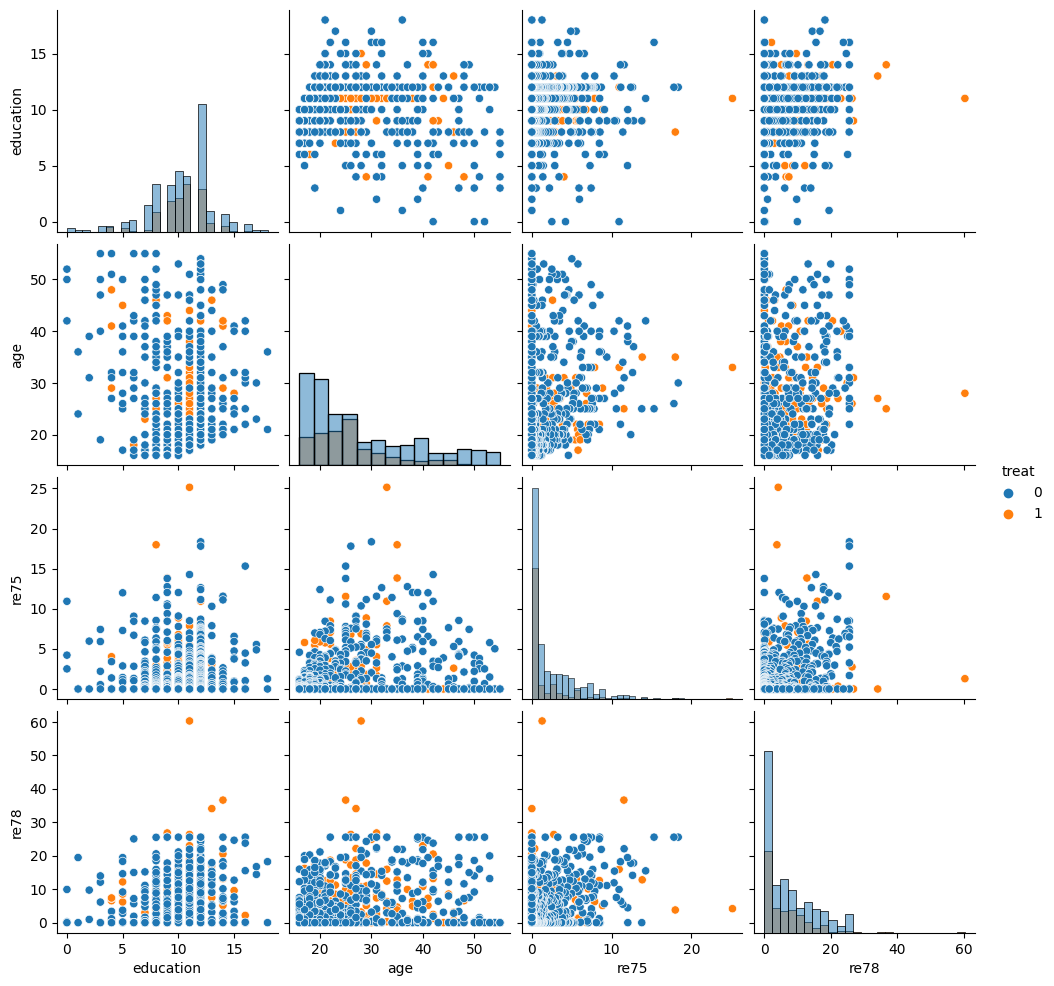

In [4]:
# Visualize the data
sns.pairplot(df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist")

In [5]:
# Evaluate what our answer would be if we just naively predicted the average earnings of treated and untreated individuals, 
# without accounting for the potential confounders.
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]

naive_prediction = (treated_individuals["re78"].mean() - untreated_individuals["re78"].mean())
naive_prediction

-0.6350262120374222

## Causal Probabilistic Program

Our causal assumptions can be encoded as a probabilistic program in Pyro. Here, unlike in the [Tutorial](tutorial_i.ipynb), we'll write a probabilistic program in a single pass that includes the causal relationships between attributes and the priors over parameters.

### Model Description

As our assumptions are relatively straightforward, they can be codified entirely in the ordering of random variables in our causal probabilistic program. Specifically, we have written our `causal_model` method below such that `covariates` influence `training` and `earnings`, and `training` influences `earnings`. To align this model with the specific parametric assumptions used in our case study [@lalonde1986evaluating], we have chosen to use a logistic function to describe the mechanism for generating `training` random variables, and a linear Gaussian model for generating `earnings`.

### Prior Description

In order to represent our uncertainty over causal models, we place `Normal`, `HalfCauchy`, and `LKJCholesky` priors on each of the 8 parameters used in our `causal_model`. For each, we choose the prior based on the desired support of the parameter. E.g. variances are strictly positive, therefore we choose a `HalfCauchy` distribution.

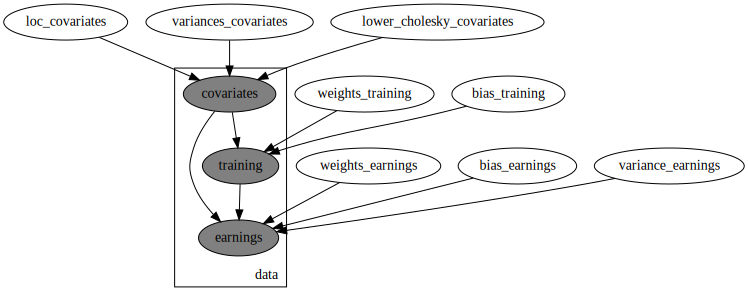

In [29]:
class BayesianBackdoor(PyroModule):
    def __init__(self, n=None, d_covariates=7, include_prior=True):
        super().__init__()
        self.n = n
        self.include_prior = include_prior
        self.d_covariates = d_covariates

    @PyroSample
    def loc_covariates(self):
        loc_prior = torch.concat((torch.tensor([10., 35., 15.]), torch.ones(self.d_covariates-3) * 0.5), dim=0)
        variance_prior = torch.ones(self.d_covariates)
        return dist.Normal(loc_prior, variance_prior).to_event(1)

    @PyroSample
    def variances_covariates(self):
        return dist.HalfCauchy(torch.ones(self.d_covariates)).to_event(1)
        
    @PyroSample
    def lower_cholesky_covariates(self):
        return dist.LKJCholesky(self.d_covariates, 1)

    @PyroSample
    def weights_training(self):
        loc_prior = torch.zeros((self.d_covariates, 1))
        # Attempt to scale weights by variance of covariates
        variance_prior = torch.ones((self.d_covariates, 1)) / torch.concat((torch.tensor([10., 35., 15.]), torch.ones(self.d_covariates-3) * 0.5), dim=0)
        return dist.Normal(loc_prior, variance_prior).to_event(2)

    @PyroSample
    def bias_training(self):
        return dist.Normal(torch.tensor([0.]), torch.tensor([10.])).to_event(1)

    @PyroSample
    def weights_earnings(self):
        loc_prior = torch.zeros((self.d_covariates, 2))
        variance_prior = torch.ones((self.d_covariates, 2)) / torch.concat((torch.tensor([[10., 10.], [35., 35.], [15., 15.]]), torch.ones(self.d_covariates-3, 2) * 0.5), dim=0)
        return dist.Normal(loc_prior, variance_prior).to_event(2)
    
    @PyroSample
    def bias_earnings(self):
        loc_prior = torch.zeros(2)
        variance_prior = torch.ones(2) * 10
        return dist.Normal(loc_prior, variance_prior).to_event(1)
    
    @PyroSample
    def variance_earnings(self):
        return dist.HalfCauchy(torch.ones(2) * 10).to_event(1)

    def causal_model(self,
                    loc_covariates, 
                    variances_covariates,
                    lower_cholesky_covariates, 
                    weights_training, 
                    bias_training, 
                    weights_earnings, 
                    bias_earnings, 
                    variance_earnings):

        # Sample covariates from a multivariate normal distribution     
        scale_tril = torch.diag_embed(variances_covariates.sqrt()) @ lower_cholesky_covariates
        covariates = pyro.sample("covariates", dist.MultivariateNormal(loc_covariates, scale_tril=scale_tril))
        
        # Sample training (treatment) from a logistic function of the covariates
        logit_training = (covariates @ weights_training)[..., 0] + bias_training
        training = (pyro.sample("training", dist.Bernoulli(torch.special.expit(logit_training)))).long()

        # Sample earnings (outcome) from a linear Gaussian function of the covariates and the treatment
        loc_earnings = pyro.ops.indexing.Vindex(covariates @ weights_earnings)[..., training] + bias_earnings[..., training]
        earnings = pyro.sample("earnings", dist.FoldedDistribution(dist.Normal(loc_earnings, variance_earnings[..., training])))
        
        return covariates, training, earnings

    def get_n(self, covariates_obs=None, training_obs=None, earnings_obs=None):
        if not covariates_obs is None:
            # Little hack to allow sampling without observations
            n = covariates_obs.shape[0]
        elif not training_obs is None:
            n = training_obs.shape[0]
        elif not earnings_obs is None:
            n = earnings_obs.shape[0]
        else:
            n = self.n
        return n

    def forward(self, covariates_obs=None, training_obs=None, earnings_obs=None):

        n = self.get_n(covariates_obs, training_obs, earnings_obs)

        with pyro.poutine.mask(mask=self.include_prior):
            params = (self.loc_covariates, self.variances_covariates, self.lower_cholesky_covariates, self.weights_training, self.bias_training, self.weights_earnings, self.bias_earnings, self.variance_earnings)

        with pyro.plate("data", n, dim=-1):
            with pyro.condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs}):
                return self.causal_model(*params)

bayesian_backdoor = BayesianBackdoor()
pyro.render_model(bayesian_backdoor, model_args=(covariates_obs, training_obs, earnings_obs))

### Informal Prior Predictive Check - Visualizing Samples

As this model involved several priors over multiple parameters, it is helpful to probe some implications of these modeling decisions on the induced distribution over individual attributes. As we always expect to be conditioning on covariates in our analyses, we only focus on sampling from the prior distribution on `training` and `earnings` random variables conditional on the observed `covariates_obs`.

In [30]:
def plot_predictive(model, covariates_obs, training_obs, earnings_obs, guide=None, compare_source=True, queried=False):

    if guide:
        guide_tr = trace(guide).get_trace(covariates_obs, training_obs, earnings_obs)
        model_tr = trace(replay(model, trace=guide_tr)).get_trace(covariates_obs, training_obs, earnings_obs)
    else:
        model_tr = trace(model).get_trace(covariates_obs, training_obs, earnings_obs)

    covariates = model_tr.nodes['covariates']['value']
    training = model_tr.nodes['training']['value'][:, None]
    # Note: Indexing into counterfactual variables is a little awkward.

    if queried:
        earnings = model_tr.nodes['earnings_observed']['value'][0, 0, :, None]
    else:
        earnings = model_tr.nodes['earnings']['value'][:, None]

    samples = torch.concat((training, covariates, earnings), dim=1).detach().numpy()

    predictive_df = pd.DataFrame(samples, columns=["treat", *covariates_names, "re78"]).astype({"treat":"int8"})

    data_copy = df.copy()
    data_copy["source"] = "data"

    predictive_copy = predictive_df.copy()
    predictive_copy["source"] = "predictive"

    if compare_source:
        sns.pairplot(pd.concat((data_copy, predictive_copy), ignore_index=True)[["treat", "education", "age", "re75", "re78", "source"]], hue="source", diag_kind="hist")
    else:
        sns.pairplot(predictive_df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist")

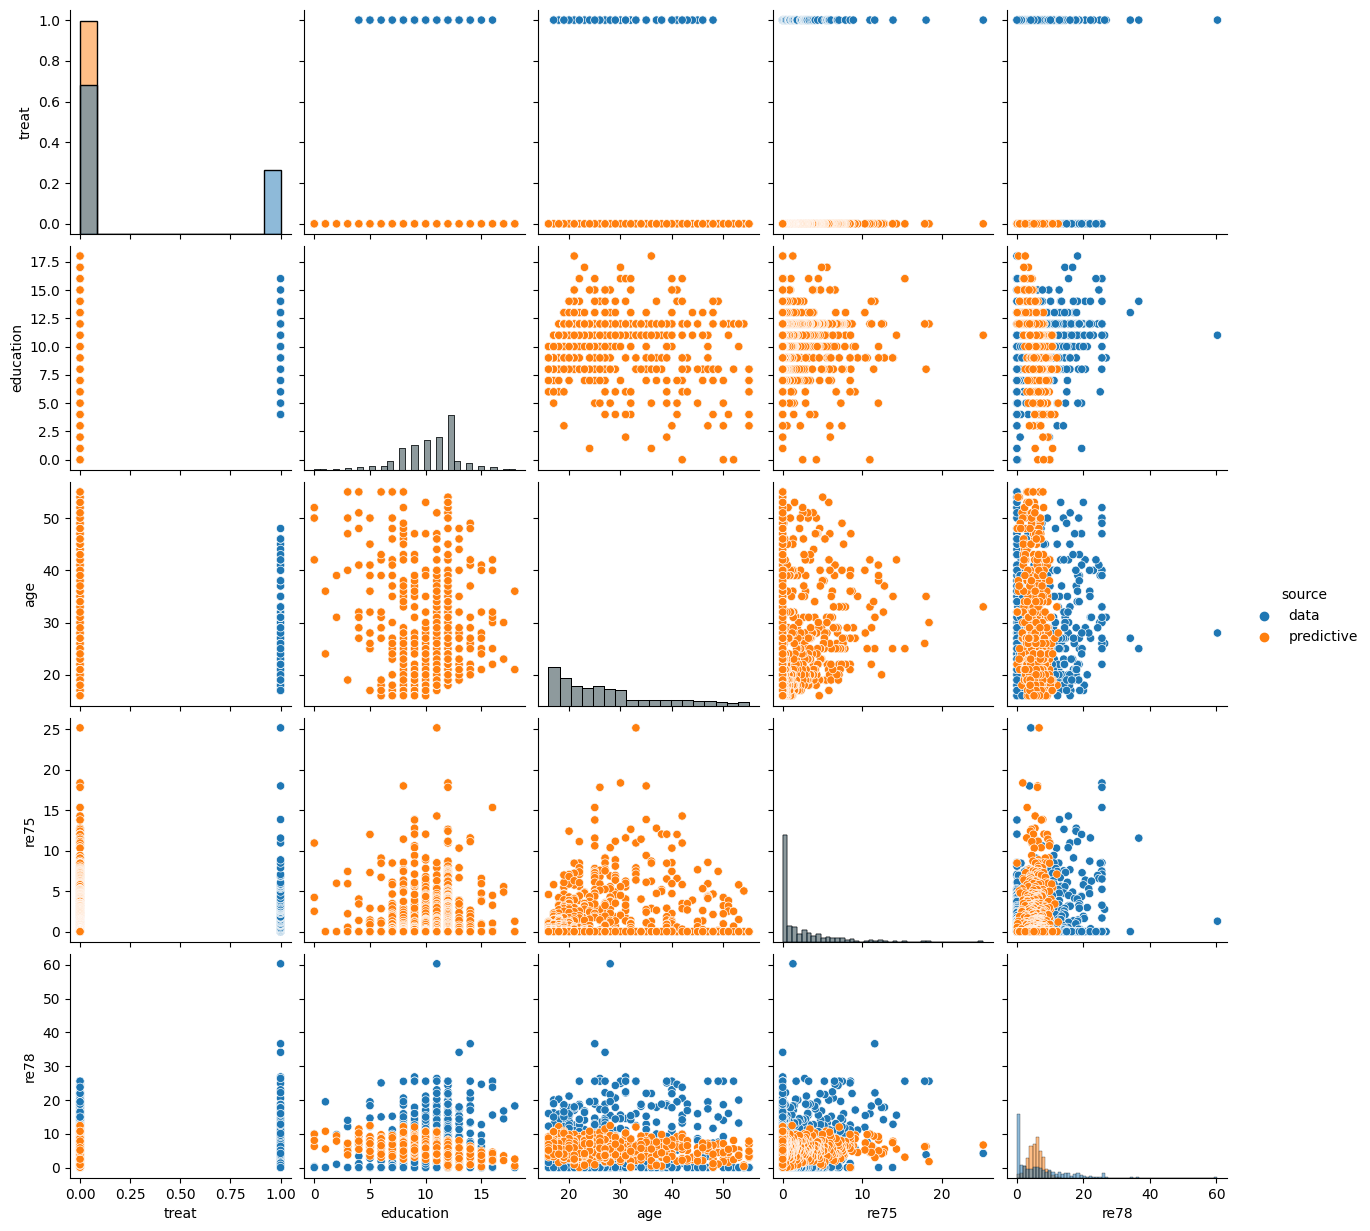

In [31]:
plot_predictive(bayesian_backdoor, covariates_obs, None, None)

## Causal Query: average treatment effect (ATE)

In this setting we wish to compute the *average treatment effect*, $ATE = \mathbb{E}[Y=1|do(T=1)] - \mathbb{E}[Y=1|do(T=0)]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $T$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $T$ in the original `causal_model`, which assumes $X$ and $T$ are dependent.

In words, in this setting the ATE tells us how much greater the salaries across all individuals if we forced everyone to participate in the job training program relative to if we forced everyone to not participate in the job training program. Here, we are interested in the average over the entire population. Other estimands, such as the conditional average treatment effect, may be interested in the average effect for individuals with particular attributes of interest.

To implement this query in Causal Pyro we extend our `BayesianBackdoor` model by applying two interventions, `do(actions={"training":0})` and `do(actions={"training":1})`, and then sampling jointly from counterfactual worlds using the `MultiWorldCounterfactual` handler. Recall from the [tutorial](tutorial_i.ipynb) that the `MultiWorldCounterfactual` handler modifies the execution of the causal model to sample jointly from the observational and all counterfactual worlds induced by an intervention.

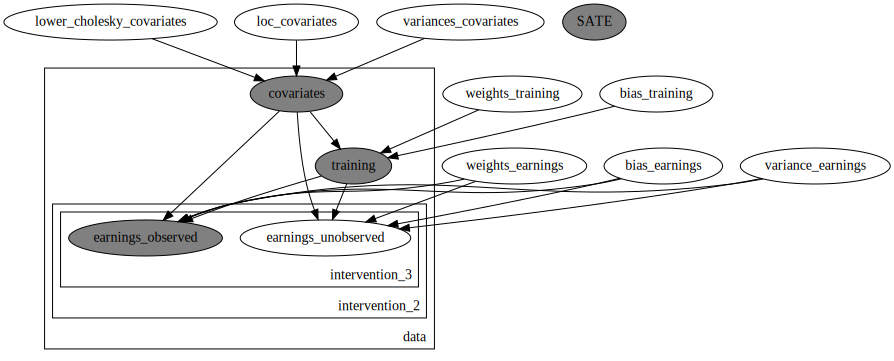

In [38]:
class BayesianBackdoorSATE(BayesianBackdoor):
    def __init__(self, n=None, d_covariates=7, include_prior=True):
        super().__init__(n, d_covariates, include_prior)

    def forward(self, covariates_obs, training_obs, earnings_obs):

        n = self.get_n(covariates_obs, training_obs, earnings_obs)

        # Apply interventions to the model
        extended_model = do(actions={"training": 0})(
                            do(actions={"training": 1})(
                                super().forward))

        # Sample jointly from observational and counterfactual distributions
        with MultiWorldCounterfactual(-2):
            _, _, earnings_cf = extended_model(covariates_obs, training_obs, earnings_obs)
        
        # Evaluate the sample average treatment effect
        earnings_treatment = earnings_cf[..., 0, 1, :]
        earnings_control = earnings_cf[..., 1, 0, :]
        return pyro.deterministic("SATE", torch.sum(earnings_treatment - earnings_control, dim=-1) / n)

bayesian_backdoor_sate = BayesianBackdoorSATE()
pyro.render_model(bayesian_backdoor_sate, model_args=(covariates_obs, training_obs, earnings_obs))

## Causal Inference as Probabilistic Inference

In this section we show the use of multiple variants of Pyro's stochastic variational inference to solve our causal inference problem. 

In [35]:
# Optimization parameters used throughout
initial_lr = 0.03
adam = pyro.optim.Adam({'lr': initial_lr})
elbo = pyro.infer.Trace_ELBO(num_particles=5, vectorize_particles=True)

In [36]:
def run_inference(covariates_obs, training_obs, earnings_obs, model, guide, optim=adam, loss=elbo, num_predictive_samples=1000, num_iterations=1000, verbose=False):
    svi = SVI(model, guide, optim, loss=loss)
    predictive = Predictive(model, guide=guide, num_samples=num_predictive_samples)

    pyro.clear_param_store()

    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(covariates_obs, training_obs, earnings_obs)
        if verbose:
            if j % 100 == 0:
                print("[iteration %04d] loss: %.4f - SATE estimate: %.2f" % (j + 1, loss / len(covariates_obs), predictive(covariates_obs, training_obs, earnings_obs)['SATE'].mean()))
    
    return predictive(covariates_obs, training_obs, earnings_obs)["SATE"]


### Maximum Likelihood Inference

Here we implement maximum likelihood inference by setting `include_prior=False`, masking out the contribution of the parameter priors when computing the joint density of a trace in Pyro's SVI, and by using an `AutoDelta` variational approximation.

[iteration 0001] loss: 431.2437 - SATE estimate: 1.87
[iteration 0101] loss: 251.6280 - SATE estimate: 1.04
[iteration 0201] loss: 242.2809 - SATE estimate: 1.30
[iteration 0301] loss: 239.6392 - SATE estimate: 1.48
[iteration 0401] loss: 238.5564 - SATE estimate: 1.56
[iteration 0501] loss: 238.0271 - SATE estimate: 1.59
[iteration 0601] loss: 237.7352 - SATE estimate: 1.61
[iteration 0701] loss: 237.5592 - SATE estimate: 1.61
[iteration 0801] loss: 237.4432 - SATE estimate: 1.61
[iteration 0901] loss: 237.3603 - SATE estimate: 1.61


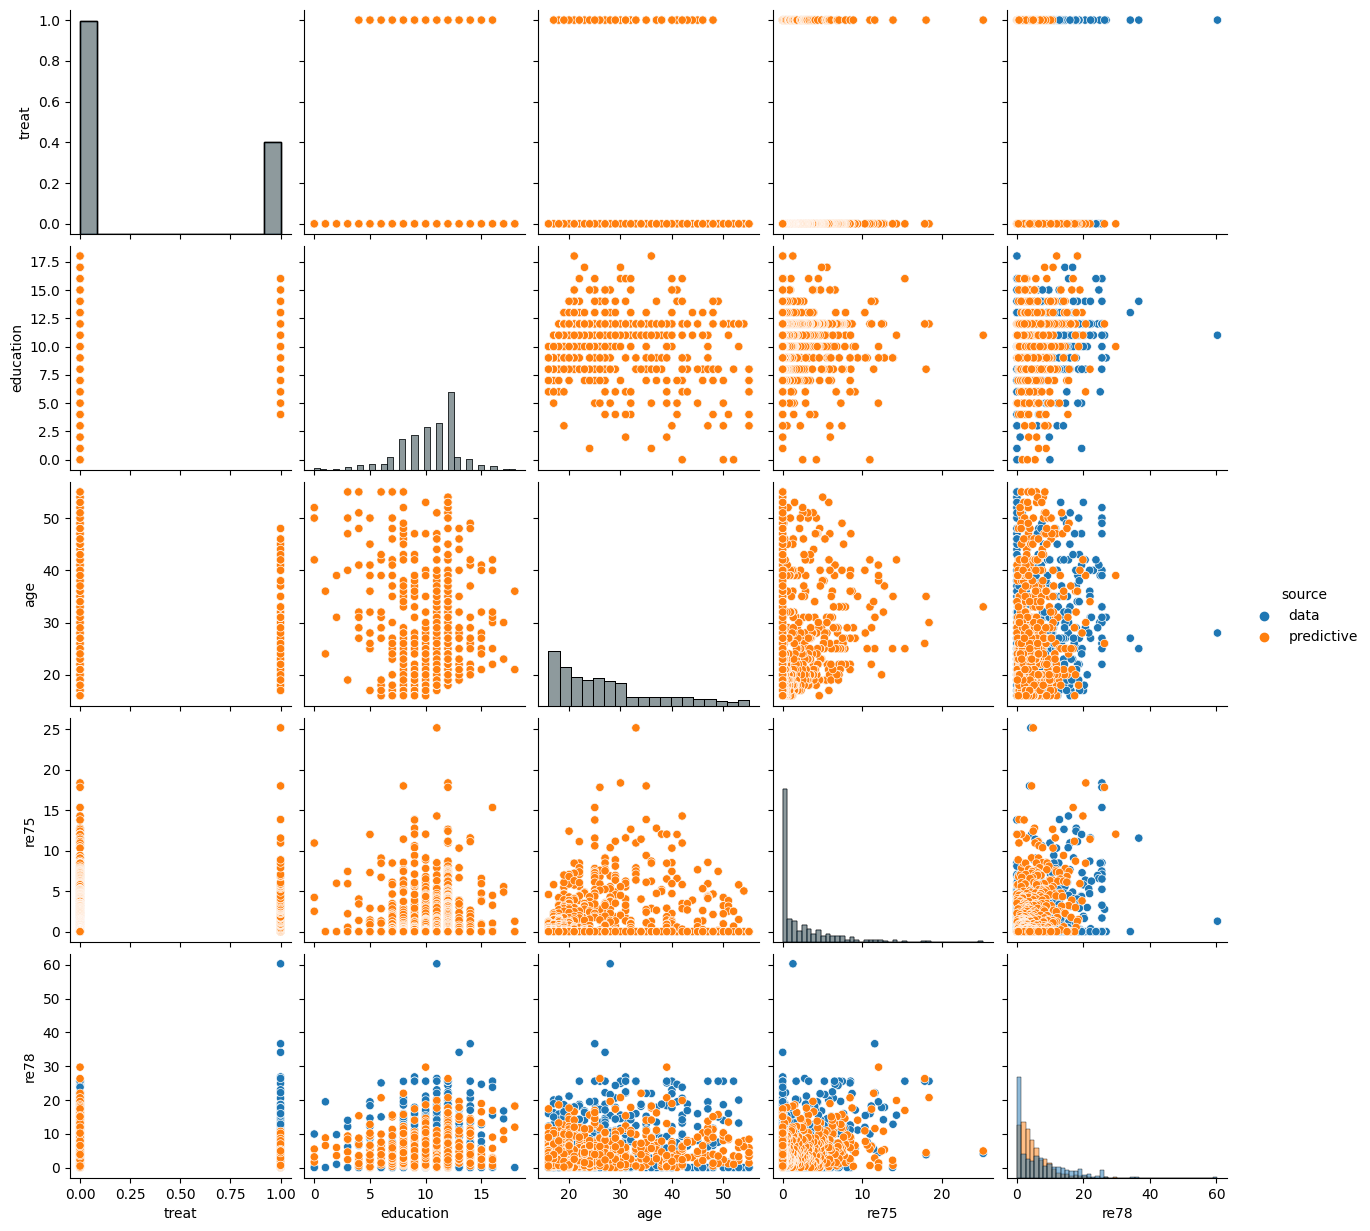

In [39]:
ml_model = BayesianBackdoorSATE(include_prior=False)

ml_guide = AutoDelta(ml_model)

ml_prediction = run_inference(covariates_obs, training_obs, earnings_obs, ml_model, ml_guide, num_predictive_samples=1, verbose=True)

# Visualize posterior predictive sample
plot_predictive(ml_model, covariates_obs, training_obs, None, guide=ml_guide, queried=True)

### Maximum a Posteriori Inference

Here we implement maximum a posterior inference by setting `include_prior=True`, now including the contribution of the parameter priors when computing the joint density of a trace in Pyro's SVI, and by using an `AutoDelta` variational approximation.

[iteration 0001] loss: 604.0558 - SATE estimate: -0.94
[iteration 0101] loss: 270.7251 - SATE estimate: 0.79
[iteration 0201] loss: 250.3520 - SATE estimate: 1.06
[iteration 0301] loss: 244.2820 - SATE estimate: 1.21
[iteration 0401] loss: 241.6481 - SATE estimate: 1.32
[iteration 0501] loss: 240.2709 - SATE estimate: 1.36
[iteration 0601] loss: 239.4634 - SATE estimate: 1.38
[iteration 0701] loss: 238.9643 - SATE estimate: 1.42
[iteration 0801] loss: 238.6384 - SATE estimate: 1.42
[iteration 0901] loss: 238.4135 - SATE estimate: 1.43


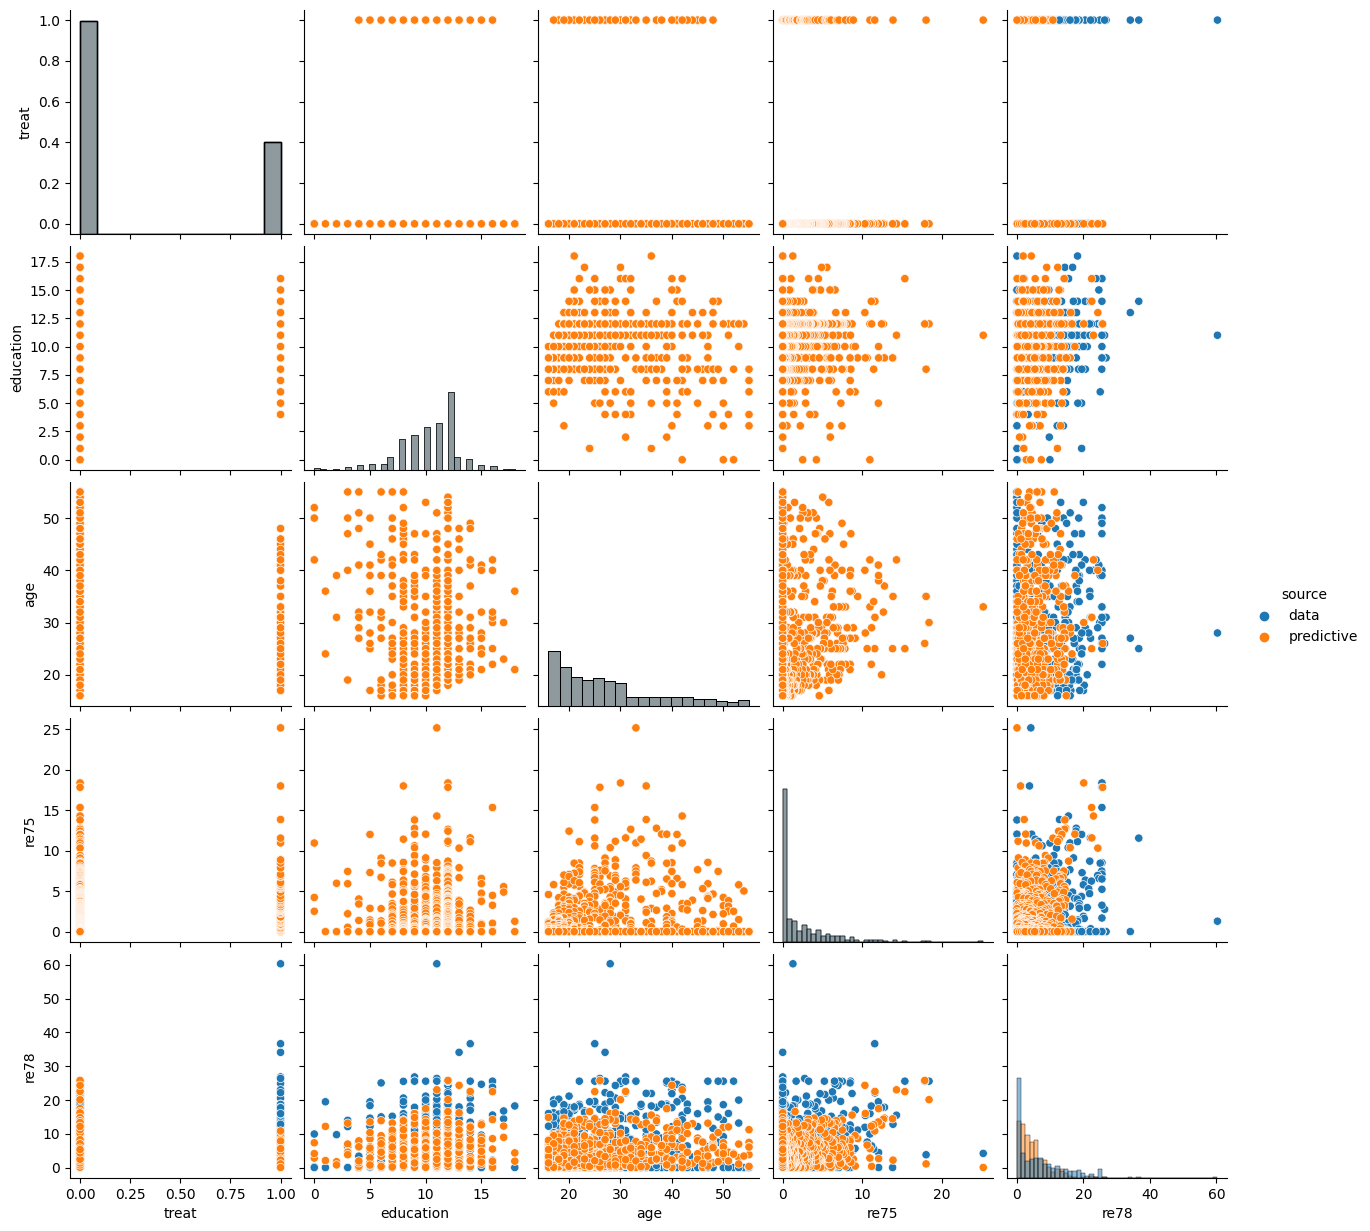

In [40]:
map_model = BayesianBackdoorSATE(include_prior=True)

map_guide = AutoDelta(map_model)

map_prediction = run_inference(covariates_obs, training_obs, earnings_obs, map_model, map_guide, num_predictive_samples=1, verbose=True)

# Visualize posterior predictive sample
plot_predictive(map_model, covariates_obs, training_obs, None, guide=map_guide, queried=True)

### Gaussian Mean Field Variational Inference

Here we implement mean field variational inference by replacing the `AutoDelta` variational family constructor with an `AutoNormal`. In addition, we make some minor changes to the optimizer.

In [41]:
# Using default Adam we run into numerical instability problems, and optimization terminates with nans.

gamma = 0.2  # final learning rate will be gamma * initial_lr
num_iterations = 1000
lrd = gamma ** (1 / num_iterations)
clp_adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd}) 

[iteration 0001] loss: 1707.4742 - SATE estimate: 0.00
[iteration 0101] loss: 257.5265 - SATE estimate: 1.27
[iteration 0201] loss: 233.3418 - SATE estimate: 1.32
[iteration 0301] loss: 229.7129 - SATE estimate: 1.36
[iteration 0401] loss: 227.5107 - SATE estimate: 1.40
[iteration 0501] loss: 225.5189 - SATE estimate: 1.43
[iteration 0601] loss: 224.1906 - SATE estimate: 1.48
[iteration 0701] loss: 222.9474 - SATE estimate: 1.51
[iteration 0801] loss: 221.9578 - SATE estimate: 1.50
[iteration 0901] loss: 221.0379 - SATE estimate: 1.52


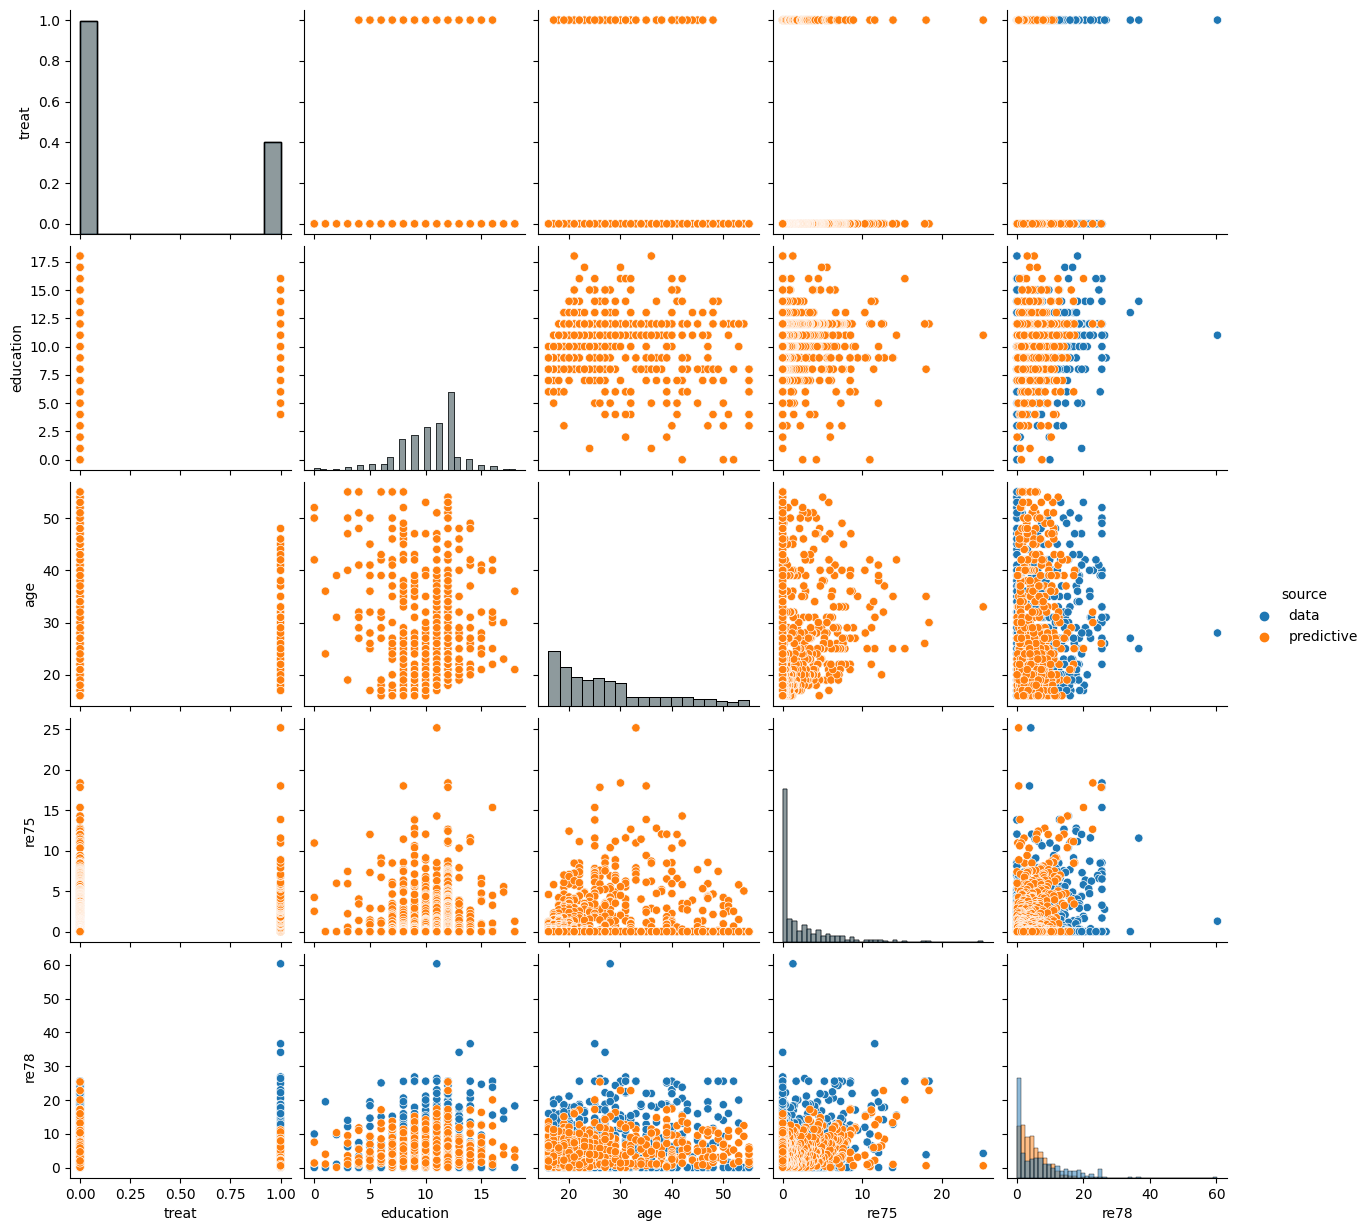

In [42]:
mf_model = BayesianBackdoorSATE(include_prior=True)

mf_guide = AutoNormal(mf_model)

mf_prediction = run_inference(covariates_obs, training_obs, earnings_obs, mf_model, mf_guide, optim=clp_adam, num_iterations=num_iterations, verbose=True)

# Visualize posterior predictive sample
plot_predictive(mf_model, covariates_obs, training_obs, None, guide=mf_guide, queried=True)

## Results

Here, we compare the results of our probabilsitic programming approach compared with a standard implementation of linear regression for causal inference.

In [43]:
# https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html
blog_prediction = 1548.24 / 1000 # Scaled by 1000 to be consistent with data preprocessing above.

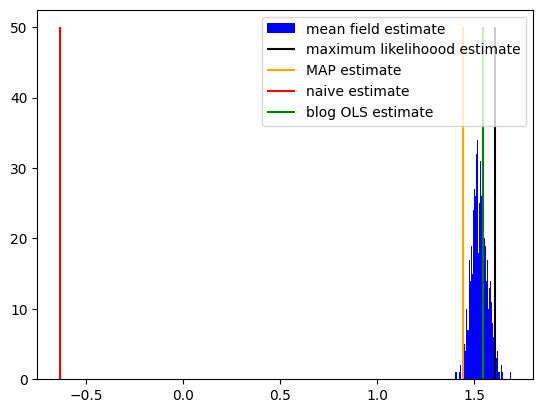

In [44]:
fig, ax = plt.subplots(1, 1)
ax.hist(mf_prediction.squeeze(), bins=100, color="blue", label="mean field estimate")
ax.vlines(ml_prediction.mean(), 0, 50, color="black", label="maximum likelihoood estimate")
ax.vlines(map_prediction.mean(), 0, 50, color="orange", label="MAP estimate")
ax.vlines(naive_prediction, 0, 50, color="red", label="naive estimate")
ax.vlines(blog_prediction, 0, 50, color="green", label="blog OLS estimate")
ax.legend()

Here, we can clearly see that all three of our approximate inference variants closely agree with prior results using linear regression. All solutions differ substantially from the naive estimate that simply ignores covariates altogether.